# Simulation on:
### Grouped Patterns of Heterogeneity in Panel Data, Bonhomme, S. and Manresa, E. (2015)

In [1]:
# %matplotlib notebook 
# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 4]

os.chdir(r"GFE_generic")

# Setup
Initialize a dataset with 10 individual units divided into 3 grous spanning 20 periods. Assigning group membership randomly using unifrom distribution. In addition, choosing time trend (drift term) for the groups. 

In [2]:
np.random.seed(seed=10) # used in random group assignment

nt = 20 # number of periods
nc = 10 # number of units/countries
ng = 3  # number of groups

gtrend = np.random.randint(-10,10,ng) # create integer trend within [-10;10] for each group

gtresh      = np.linspace(0,1,ng+1)[:-1]                   # linear treshold to randomly divide into groups
group_place = np.random.random(nc)                         # assign uniform RN to each unit for dividing into groups
cg          = [np.argmin(i>gtresh)+1 for i in group_place] # where the assigned RN are located in grid of thresholds

print(f'Thresholds for group assignment: {gtresh}')
print(f'Trends for each group: {gtrend}')
print(f'Assigned groups: {cg}')

Thresholds for group assignment: [0.         0.33333333 0.66666667]
Trends for each group: [-1 -6  5]
Assigned groups: [3, 1, 3, 2, 2, 1, 2, 2, 1, 1]


# Creating trends

Stochastic trend with drift. Stochastic trend shocks are mean 0 and with the standard deviation of 25. 

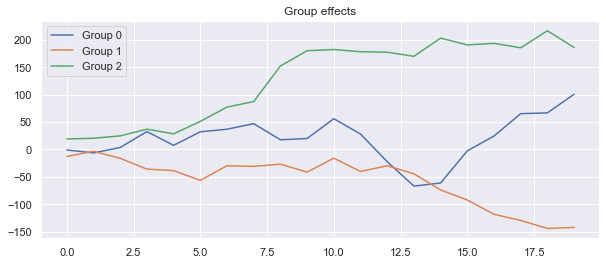

In [3]:
# Effects for groups
groups = {}
for i in range(ng):
    ds = [0]
    for y in range(nt):
        ds.append(ds[-1]+gtrend[i]+np.random.normal(scale=25)) # drift, normal random disturbances with std=25
        
    groups['g'+str(i+1)+'t'] = ds[1:] # group i's effect
    plt.plot(groups['g'+str(i+1)+'t'], label='Group ' + str(i))

plt.title('Group effects')
plt.legend()

# Create panel data based on groups, group trends, covariates and noise

Since the trend is known for each group and group assignment is known, now generate individual series by adding noises to the trend and covariates. For covariates and corresponding parameters, here I am using arbitrary numbers. However, note that the coefficients of the covariates are fixed over groups and individual (time varying covariates effect was mentioned in the paper as an extension).

In [4]:
# Panel elements
group_effect, X1, X2, time, individual, i_group = [],[],[],[],[],[]
beta_X1, beta_X2, std_u = 15, 5, 10  # coefficients of covariates and std of error term
rho_1,rho_2 = 0.5, 0.5               # correlation coef. of covariates with group effects [normal covariates with the same std as the group effects]

for i, group in enumerate(cg):
    # panel elements for unit i being added to big panel
    g_effect_i = np.array(groups['g'+str(group)+'t'])
    group_effect.extend(g_effect_i)      # group effects
    X1_i = rho_1*g_effect_i+np.sqrt(1-rho_1**2)*np.random.normal(scale = np.std(g_effect_i), size=len(g_effect_i))
    X1.extend(X1_i)
    X2_i = rho_2*g_effect_i+np.sqrt(1-rho_2**2)*np.random.normal(scale = np.std(g_effect_i), size=len(g_effect_i))
    X2.extend(X2_i)
    time.extend(np.arange(nt))         # time indicators
    individual.extend(np.full(nt,i))   # individual indicators
    i_group.extend(np.full(nt,group))  # group indicators

# Construct a dataframe from the panel    
df               = pd.DataFrame()
df['X1']         = X1
df['X2']         = X2
df['group_effect']= group_effect
df['u']          = std_u*np.random.randn(len(group_effect))
df['Y']          = df['group_effect'] + beta_X1*df['X1']  + beta_X2*df['X2'] + df['u']

# just indicators
df['time']       = time
df['individual'] = individual
df['group']      = i_group

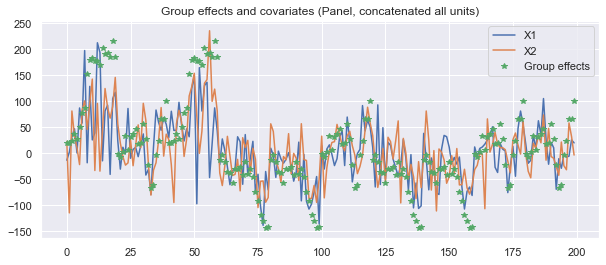

In [5]:
# How do covariates look like versus group effects for panel in total?
plt.plot(df['X1'], label='X1')
plt.plot(df['X2'], label='X2')
plt.plot(df['group_effect'],'*', label='Group effects')
plt.title('Group effects and covariates (Panel, concatenated all units)')
plt.legend()

In [6]:
# All panel in dataframe
df.head()

,X1,X2,group_effect,u,Y,time,individual,group
0,-13.054749,23.121279,19.128817,3.463516,-57.622505,0,0,3
1,2.615006,-114.224159,20.443310,9.423645,-502.028747,1,0,3
2,32.324981,81.516413,24.795677,-3.854768,913.397694,2,0,3
3,47.270850,33.770526,37.023032,15.602088,930.540503,3,0,3
4,0.798210,10.399852,28.526055,15.451618,107.950079,4,0,3


Text(0.5, 1.0, 'Time series (individual units)')

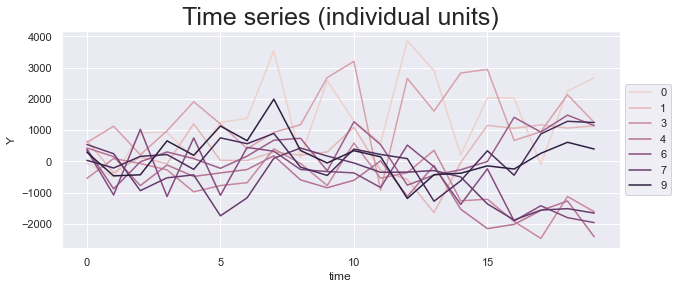

In [7]:
# Visualize by individuals
sns.lineplot(data=df,x='time',y='Y',hue='individual')
plt.xticks(np.arange(0, nt, step=5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Time series (individual units)",fontsize=25)

Text(0.5, 1.0, 'Time series (groups (with bands))')

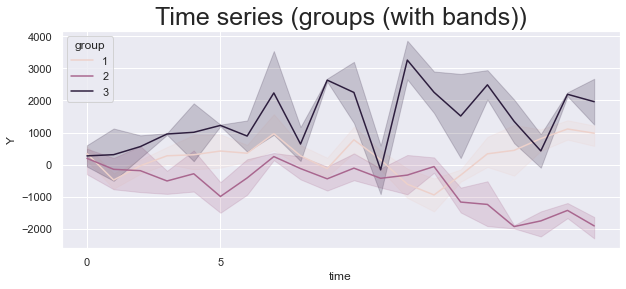

In [8]:
# Visualize by groups
sns.lineplot(data=df,x='time',y='Y',hue='group')
plt.xticks(np.arange(0, nc, step=5))
plt.title("Time series (groups (with bands))",fontsize=25)

# Export to STATA to process it with the author's toolbox

In [9]:
df.to_stata(r'df.dta')

# Running authors' the toolbox

* Put data file (df.dta in our case), Bootstrap_version.exe and GFE_code.do files in the same directory. 
* Configure GFE_code.do (adjust USER INPUTS). 
* Then run GFE_code, fill in the prompted inputs, accordingly.
* DATA_GFE.dta will be generated in the same folder. This data file contains group information. 


When running GFE_code.do, choose the following parameters:

* Adjust the data directory path in line 87, "GFE_generic" in our case.
* Number of groups: type “3” if number of groups is 3. 
* Number of covariates: type “2” if number of covariates is 2.
* Algorithm: type “1” (for Algorithm 2).
* Number of simulations: type “10”.
* Number of neighbors: type “10”
* Number of steps: type “10”.
* Standard errors: type “1” (for bootstrapped standard errors).
* Algorithm: type “1” (for Algorithm 2).
* Number of simulations: type “5”.
* Number of neighbors: type “10”.
* Number of steps: type “5”.
* Number of bootstrap replications: type “100”.

# Results

Import 'DATA_GFE.dta', the output of the toolbox which has an additional column with group information on top of the original data. 

In [10]:
# Estimated groups, exploring min, max, mean just to confirm that the assigned groups do not vary over time.
df_gfe = pd.read_stata(r'DATA_GFE.dta')
df_gfe.groupby('individual').agg({'assignment':['mean','max','min']})


assignment        
                 mean max min
individual                   
0                   2   2   2
1                   1   1   1
2                   2   2   2
3                   3   3   3
4                   3   3   3
5                   1   1   1
6                   3   3   3
7                   3   3   3
8                   1   1   1
9                   1   1   1

Compare if the group assigned by the estimator to the actual group memberships.

In [11]:
print('Assigned groups: {}'.format(cg))

est_g = df_gfe.groupby('individual')['assignment'].agg('mean').to_list()
print('Estimated groups: {}'.format(est_g))

assert cg == est_g, "Mismatch in groups OR MAYBE just a different ordering of groups by the toolbox!"

Assigned groups: [3, 1, 3, 2, 2, 1, 2, 2, 1, 1]
Estimated groups: [2, 1, 2, 3, 3, 1, 3, 3, 1, 1]


AssertionError: Mismatch in groups OR MAYBE just a different ordering of groups by the toolbox!

# The end of simulation